In [658]:
from datetime import datetime, timedelta, timezone
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

download the model, then download the next 7 days weather forecast -make prediction, and dashboard

In [659]:
today = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)
today

datetime.datetime(2024, 11, 18, 0, 0)

In [660]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']
url=location['aqicn_url']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [661]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

Model registry

In [662]:
mr= project.get_model_registry()

retrieved_model=mr.get_model(
    name="air_quality_xgboost_model",
    version=7,
)

saved_model_dir=retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [663]:
retrieved_xgboost_model=XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir+"/model.json")

retrieved_xgboost_model

XGBRegressor(base_score='2.4931547E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [664]:
weather_fg= fs.get_feature_group(
    name='weather',
    version=1,
)

batch_data= weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by=['date']).reset_index(drop=True)

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-18 00:00:00+00:00,2.40,0.0,12.324414,276.709747,stockholm
1,2024-11-19 00:00:00+00:00,1.25,0.0,5.241679,74.054535,stockholm
2,2024-11-20 00:00:00+00:00,1.25,0.2,22.551060,343.300690,stockholm
3,2024-11-21 00:00:00+00:00,-2.45,0.0,21.986542,309.685394,stockholm
4,2024-11-22 00:00:00+00:00,-4.95,0.0,12.245294,268.315338,stockholm
5,2024-11-23 00:00:00+00:00,-1.95,0.0,14.799459,274.184845,stockholm
6,2024-11-24 00:00:00+00:00,3.75,0.0,18.899143,139.635544,stockholm
7,2024-11-25 00:00:00+00:00,6.85,0.0,23.400002,194.250061,stockholm
8,2024-11-26 00:00:00+00:00,3.50,0.1,15.463244,282.094727,stockholm
9,2024-11-27 00:00:00+00:00,0.20,0.0,14.003029,287.969238,stockholm


In [665]:
def get_pm25_value(row):
    return row['pm25'] if not pd.isna(row['pm25']) else row['predicted_pm25']

air_quality_fg= fs.get_feature_group(
    name='air_quality',
    version=1,
)

yesterday=today - timedelta(1)

aq_batch_data= air_quality_fg.filter(air_quality_fg.date >= yesterday).read()       #Only need todays for future predictions. Makes it a dataframe
aq_batch_data = aq_batch_data.sort_values(by=['date']).reset_index(drop=True)

df_combined = pd.merge(
    aq_batch_data,
    batch_data,
    on='date',
    how='outer',  # as we want all rows
)

for index in range(len(batch_data)):
    df_combined.at[index+1,'pm25_3_days_before']=df_combined.loc[index,'pm25_2_days_before']
    df_combined.at[index+1,'pm25_2_days_before']=df_combined.loc[index,'pm25_1_day_before']
    df_combined.at[index+1, 'pm25_1_day_before']=get_pm25_value(df_combined.loc[index])

    current_features=df_combined.loc[index+1, ['pm25_1_day_before', 'pm25_2_days_before','pm25_3_days_before','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]

    current_features = pd.DataFrame(current_features.astype(float)).T       #Convert series to dataframe, and make sure the values are floats.
    next_pred=retrieved_xgboost_model.predict(current_features)
    df_combined.at[index+1,'predicted_pm25']=next_pred
    batch_data.at[index, 'predicted_pm25']=next_pred            #Has one less row, so starts earlier in index

batch_data.info()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   predicted_pm25               10 non-null     float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 488.0+ bytes


In [666]:
batch_data.head()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-18 00:00:00+00:00,2.40,0.0,12.324414,276.709747,stockholm,20.241510
1,2024-11-19 00:00:00+00:00,1.25,0.0,5.241679,74.054535,stockholm,26.648638
2,2024-11-20 00:00:00+00:00,1.25,0.2,22.551060,343.300690,stockholm,22.469687
3,2024-11-21 00:00:00+00:00,-2.45,0.0,21.986542,309.685394,stockholm,21.957649
4,2024-11-22 00:00:00+00:00,-4.95,0.0,12.245294,268.315338,stockholm,22.962479


In [667]:
batch_data.dropna(inplace=True)
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-18 00:00:00+00:00,2.40,0.0,12.324414,276.709747,stockholm,20.241510,stockholm-st-eriksgatan-83,sweden,1
1,2024-11-19 00:00:00+00:00,1.25,0.0,5.241679,74.054535,stockholm,26.648638,stockholm-st-eriksgatan-83,sweden,2
2,2024-11-20 00:00:00+00:00,1.25,0.2,22.551060,343.300690,stockholm,22.469687,stockholm-st-eriksgatan-83,sweden,3
3,2024-11-21 00:00:00+00:00,-2.45,0.0,21.986542,309.685394,stockholm,21.957649,stockholm-st-eriksgatan-83,sweden,4
4,2024-11-22 00:00:00+00:00,-4.95,0.0,12.245294,268.315338,stockholm,22.962479,stockholm-st-eriksgatan-83,sweden,5
5,2024-11-23 00:00:00+00:00,-1.95,0.0,14.799459,274.184845,stockholm,22.625965,stockholm-st-eriksgatan-83,sweden,6
6,2024-11-24 00:00:00+00:00,3.75,0.0,18.899143,139.635544,stockholm,19.402927,stockholm-st-eriksgatan-83,sweden,7
7,2024-11-25 00:00:00+00:00,6.85,0.0,23.400002,194.250061,stockholm,34.078899,stockholm-st-eriksgatan-83,sweden,8
8,2024-11-26 00:00:00+00:00,3.50,0.1,15.463244,282.094727,stockholm,24.893408,stockholm-st-eriksgatan-83,sweden,9
9,2024-11-27 00:00:00+00:00,0.20,0.0,14.003029,287.969238,stockholm,28.855717,stockholm-st-eriksgatan-83,sweden,10


In [668]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   predicted_pm25               10 non-null     float32            
 7   street                       10 non-null     object             
 8   country                      10 non-null     object             
 9   days_before_forecast_day     10 non-null     int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), obje

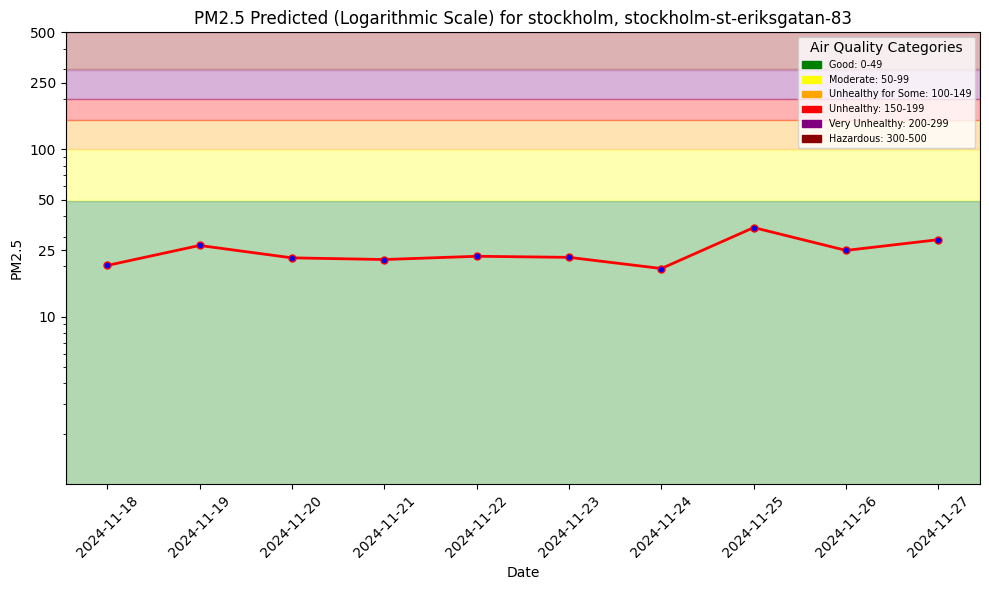

In [669]:
file_path = "docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [674]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [675]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1169559/fs/1160262/fg/1353082


Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1169559/jobs/named/aq_predictions_2_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x144c9bd00>, None)

In [676]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.22s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-18 00:00:00+00:00,2.4,0.0,12.324414,276.709747,stockholm,20.24151,stockholm-st-eriksgatan-83,sweden,1


In [677]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,date,pm25,country,city,street,url,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,pm25_average_before
0,2021-06-27 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,27.0,37.0,26.0,30.000000
1,2023-12-15 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,21.0,25.0,21.666666
2,2024-09-22 00:00:00+00:00,10.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,23.0,24.0,22.000000
3,2021-11-09 00:00:00+00:00,20.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,14.0,9.0,13.0,12.000000
4,2021-04-24 00:00:00+00:00,9.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,12.0,17.0,26.0,18.333334
...,...,...,...,...,...,...,...,...,...,...
2135,2021-12-16 00:00:00+00:00,12.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,12.0,15.0,30.0,19.000000
2136,2019-03-24 00:00:00+00:00,25.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,31.0,28.0,26.0,28.333334
2137,2020-03-13 00:00:00+00:00,17.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,16.0,26.0,33.0,25.000000
2138,2021-01-18 00:00:00+00:00,26.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,18.0,16.0,20.0,18.000000


In [678]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data

if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-18 00:00:00+00:00,20.24151,18.0


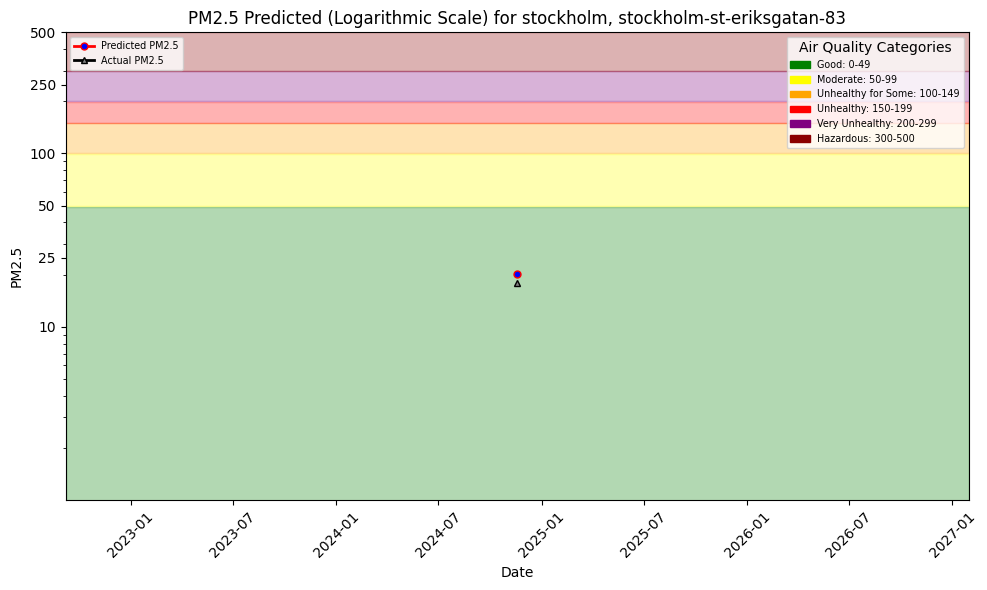

In [679]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()